In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def enhance_contrast(image_matrix, bins=256):
    image_flattened = image_matrix.flatten()
    image_hist = np.zeros(bins)

    # frequency count of each pixel
    for pix in image_matrix:
        image_hist[pix] += 1

    # cummulative sum
    cum_sum = np.cumsum(image_hist)
    norm = (cum_sum - cum_sum.min()) * 255
    # normalization of the pixel values
    n_ = cum_sum.max() - cum_sum.min()
    uniform_norm = norm / n_
    uniform_norm = uniform_norm.astype('int')

    # flat histogram
    image_eq = uniform_norm[image_flattened]
    # reshaping the flattened matrix to its original shape
    image_eq = np.reshape(a=image_eq, newshape=image_matrix.shape)

    return image_eq

In [ ]:
img1 = cv2.imread("/content/drive/MyDrive/Normal _ Stroke Patient Details/Manjula_Stroke_Haemorrhagic/GRE/Manjula GRE-13.jpg")

(-0.5, 511.5, 511.5, -0.5)

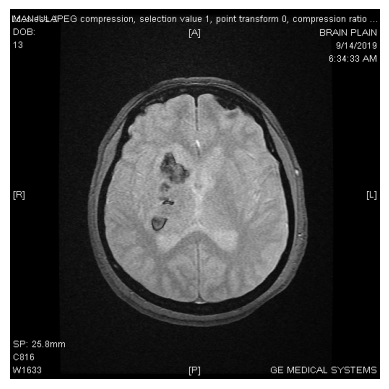

In [ ]:
plt.imshow(img1)
plt.axis("off")

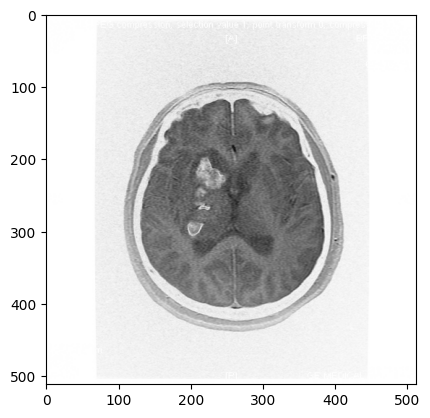

In [ ]:

mask = cv2.threshold(img1, 250, 255, cv2.THRESH_BINARY)[1][:,:,0]
dst = cv2.inpaint(img1, mask, 7, cv2.INPAINT_NS)
dst = cv2.bitwise_not(dst)
plt.imshow(dst)


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


(-0.5, 511.5, 511.5, -0.5)

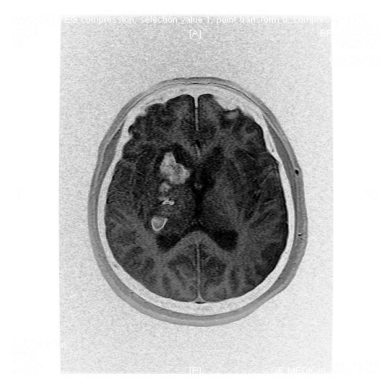

In [ ]:
plt.imshow(enhance_contrast(dst))
print(type(enhance_contrast(dst)), type(dst))
plt.axis("off")

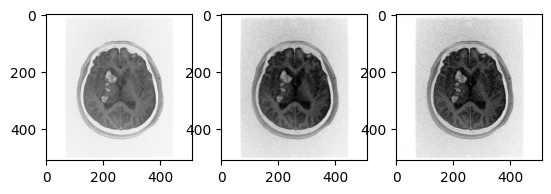

In [ ]:
from PIL import Image, ImageFilter

ax = plt.subplots(1,3)[1]

im1 = Image.fromarray(dst)
im1 = im1.filter(ImageFilter.MedianFilter(size = 3))
ax[0].imshow(im1)

im2 = Image.fromarray((enhance_contrast(dst)*1).astype(np.uint8))
im2 = im2.filter(ImageFilter.MedianFilter(size =5))
ax[1].imshow(im2)


ax[2].imshow((enhance_contrast(dst)*1).astype(np.uint8))

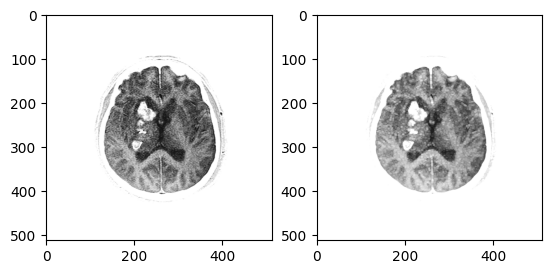

In [ ]:

ax = plt.subplots(1, 2)[1]
# plt.imshow(cv2.GaussianBlur(img_errode, (1, 1), 0))
img_bright = cv2.convertScaleAbs((enhance_contrast(dst)*1).astype(np.uint8), alpha=1.8, beta=20)
ax[0].imshow(img_bright)

kernel = np.ones((3, 3), np.uint8)
img_errode = cv2.dilate(img_bright, kernel)

ax[1].imshow(img_errode)





True

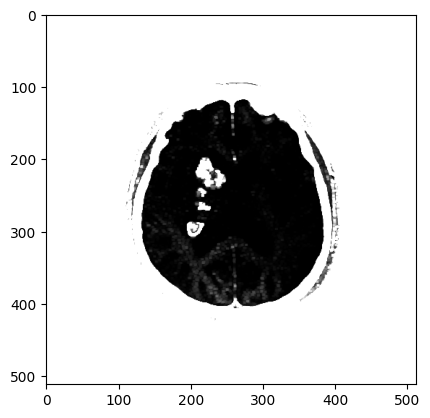

In [ ]:
def adjust_gamma(image, gamma=1.0):

   invGamma = 1.0 / gamma
   table = np.array([((i / 255.0) ** invGamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

   return cv2.LUT(image, table)

gamma = 0.1                                  # change the value here to get different result
adjusted = adjust_gamma(img_errode, gamma=gamma)
plt.imshow(adjusted)
cv2.imwrite("adjusted.png", adjusted)

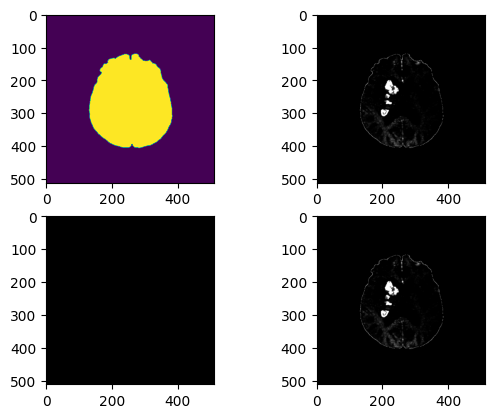

In [ ]:
ax = plt.subplots(2, 2)[1]
img = cv2.imread("/content/adjusted.png")
hh, ww = img.shape[:2]

# threshold on black
# Define lower and uppper limits of what we call "white-ish"
lower = np.array([0, 0, 0])
upper = np.array([0, 0, 0])

# Create mask to only select black
thresh = cv2.inRange(img, lower, upper)

# invert mask so shapes are white on black background
# thresh_inv = 255 - thresh
edged = cv2.Canny(img, 100, 255)

# get the largest contour
contours = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
big_contour = max(contours, key=cv2.contourArea)

# draw white contour on black background as mask
mask = np.zeros((hh,ww), dtype=np.uint8)
cv2.drawContours(mask, [big_contour], 0, (255,255,255), cv2.FILLED)

# invert mask so shapes are white on black background
# mask_inv = 255 - mask

# create new (blue) background
bckgnd = np.full_like(img, (0,0,0))

# apply mask to image
image_masked = cv2.bitwise_and(img, img, mask=mask)

# apply inverse mask to background
bckgnd_masked = cv2.bitwise_and(bckgnd, bckgnd, mask=mask)

# add together
result = cv2.add(image_masked, bckgnd_masked)

ax[0, 0].imshow(mask)
ax[0, 1].imshow(image_masked)
ax[1, 0].imshow(bckgnd_masked)
ax[1, 1].imshow(result)



True

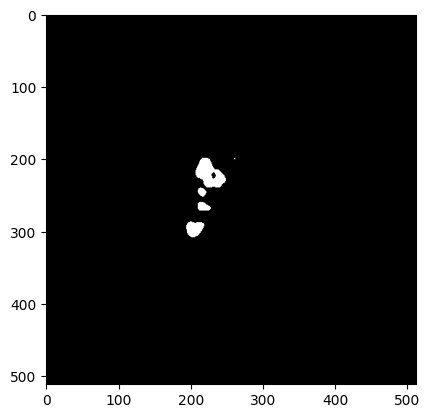

In [ ]:
blur = cv2.GaussianBlur(result,(13,13),0)
thresh = cv2.threshold(blur, 100, 255, cv2.THRESH_BINARY)[1]
plt.imshow(thresh)
cv2.imwrite("Segmented Stroke.png", thresh)

Text(0.5, 1.0, 'Segmented Stroke')

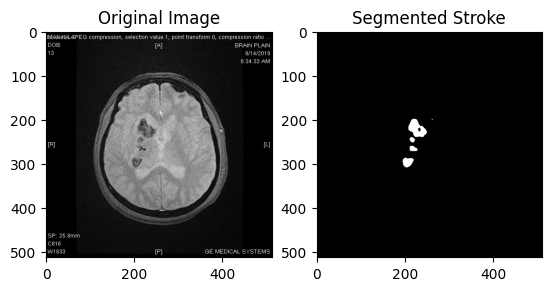

In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].imshow(img1)
ax[0].set_title("Original Image")

ax[1].imshow(thresh)
ax[1].set_title("Segmented Stroke")
